<a href="https://colab.research.google.com/github/muratkakun/Machine-Learning/blob/master/GoldPriceForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import warnings
import itertools
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers.recurrent import LSTM
from sklearn.utils import shuffle
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')

In [74]:
# Datayı Yükleyelim
data = pd.read_excel('data.xlsx', date_parser=[0])
# İlk 5 Satır
data.head()




,Tarih,AltinAlisFiyati,AltinSatisFiyati
0,2000-01-04,4.849358,4.872745
1,2000-01-05,4.825193,4.848465
2,2000-01-06,4.807271,4.830456
3,2000-01-07,4.853727,4.877136
4,2000-01-10,4.845124,4.868491


In [75]:
#Datetime Haline Getirilmesi
data['Tarih'] = pd.to_datetime(data.Tarih, format='%Y-%m')
#İndex'e Alınması
data.index = data.Tarih
data.head()


,Tarih,AltinAlisFiyati,AltinSatisFiyati
Tarih,,,
2000-01-04,2000-01-04,4.849358,4.872745
2000-01-05,2000-01-05,4.825193,4.848465
2000-01-06,2000-01-06,4.807271,4.830456
2000-01-07,2000-01-07,4.853727,4.877136
2000-01-10,2000-01-10,4.845124,4.868491


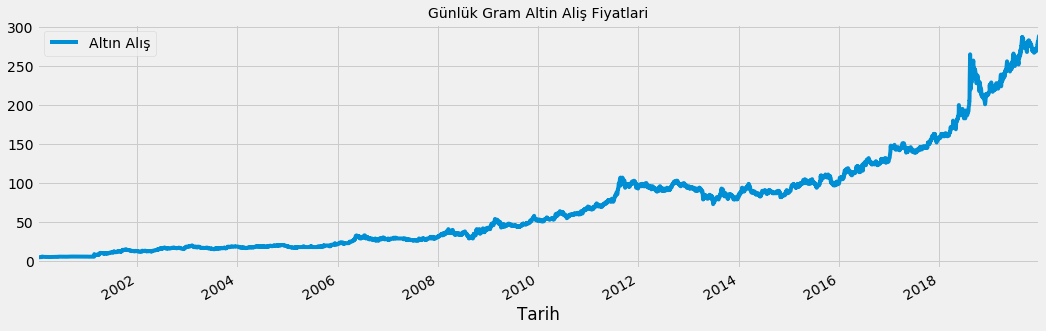

In [76]:
fig = plt.figure(figsize=(16,5))
data.AltinAlisFiyati.plot(label='Altın Alış')
plt.legend(loc='best')
plt.title('Günlük Gram Altin Aliş Fiyatlari', fontsize=14)
plt.show()


In [0]:
#Normalize
values = data['AltinAlisFiyati'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)
# Birkaç Değere Bakalım


In [78]:
TRAIN_SIZE = 0.70
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Gün Sayıları (training set, test set): " + str((len(train), len(test))))

Gün Sayıları (training set, test set): (3523, 1510)


In [0]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [0]:
use_multiple_layer = False
lossError="mae"#rmsprop,mae,mean_squared_error
epochCount = 30
window_size = 1
numberOfHiddenLayer = 200

In [81]:
# Verisetlerimizi Oluşturalım

train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)
# Yeni verisetinin şekline bakalım.
#train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
#test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print("New training data shape:")
print(train_X.shape)


Original training data shape:
(3521, 1)
New training data shape:
(3521, 1, 1)


In [0]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    # Modelin tek layerlı şekilde kurulacak.
    model.add(LSTM(numberOfHiddenLayer, input_shape = (window_size, 1), return_sequences=use_multiple_layer))
    #model ezberlemsin diye
    if(use_multiple_layer):
      model.add(Dropout(0.2))
      model.add(LSTM(numberOfHiddenLayer/2, return_sequences=False))
      #model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = lossError, optimizer = "adam")
   #30 epoch yani 30 kere verisetine bakılacak.
    print("LSTM")
    model.summary()
    model.fit(train_X, train_Y, epochs = epochCount, batch_size = 1, verbose = 1, shuffle=False)
    
    return(model)

def fit_model_gru(train_X, train_Y, window_size = 1):
    model = Sequential()
    # Modelin tek layerlı şekilde kurulacak.
    model.add(GRU(numberOfHiddenLayer, input_shape = (window_size, 1), return_sequences=use_multiple_layer))
    #model ezberlemesin diye
    if(use_multiple_layer):
      model.add(Dropout(0.2))
      model.add(GRU(numberOfHiddenLayer/2, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = lossError, optimizer = "adam")#rmsprop,mae,mean_squared_error
   #30 epoch yani 30 kere verisetine bakılacak.
    print("GRU")
    model.summary()
    model.fit(train_X, train_Y, epochs = epochCount, batch_size = 1, verbose = 1, shuffle=False)
    
    return(model)

In [83]:
def predict_and_score(model, X, Y):
    # Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    # Rmse değerlerini ölçüyoruz.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)
model1 = fit_model(train_X, train_Y, window_size)
rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

model_gru = fit_model_gru(train_X, train_Y, window_size)
rmse_train_gru, train_predict_gru = predict_and_score(model_gru, train_X, train_Y)
rmse_test_gru, test_predict_gru = predict_and_score(model_gru, test_X, test_Y)

print("Training data score: %.2f RMSE(LSTM)" % rmse_train)
print("Test data score: %.2f RMSE(LSTM)" % rmse_test)

print("Train data score: %.2f RMSE(GRU)" % rmse_train_gru)
print("Test data score: %.2f RMSE(GRU)" % rmse_test_gru)


LSTM
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3521/3521 [==============================] - 33s 9ms/step - loss: 0.0047
Epoch 2/30
3521/3521 [==============================] - 31s 9ms/step - loss: 0.0073
Epoch 3/30
3521/3521 [==============================] - 30s 9ms/step - loss: 0.0070
Epoch 4/30
3521/3521 [==============================] - 30s 8ms/step - loss: 0.0069
Epoch 5/30
3521/3521 [==============

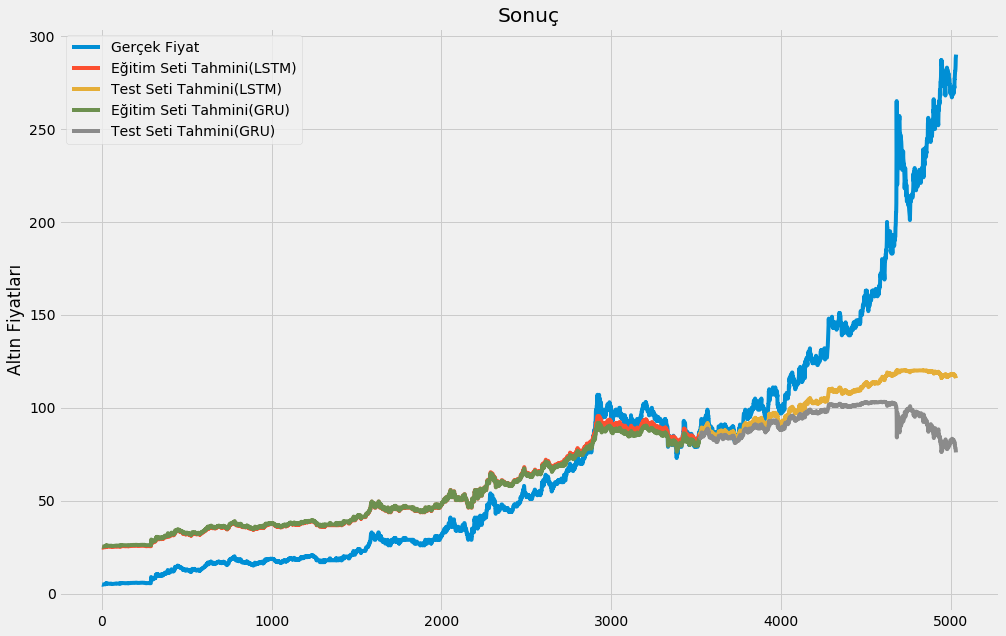

In [84]:
# Öğrendiklerinini tahminletip ekliyoruz.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict
# Şimdi ise testleri tahminletiyoruz.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Öğrendiklerinini tahminletip ekliyoruz.Gru
train_predict_plot_gru = np.empty_like(dataset)
train_predict_plot_gru[:, :] = np.nan
train_predict_plot_gru[window_size:len(train_predict_gru) + window_size, :] = train_predict_gru
# Şimdi ise testleri tahminletiyoruz.Gru
test_predict_plot_gru = np.empty_like(dataset)
test_predict_plot_gru[:, :] = np.nan
test_predict_plot_gru[len(train_predict_gru) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict_gru



# Plot'u oluşturalım.
plt.figure(figsize = (15, 10))
plt.plot(scaler.inverse_transform(dataset), label = "Gerçek Fiyat")
plt.plot(train_predict_plot, label = "Eğitim Seti Tahmini(LSTM)")
plt.plot(test_predict_plot, label = "Test Seti Tahmini(LSTM)")
plt.plot(train_predict_plot_gru, label = "Eğitim Seti Tahmini(GRU)")
plt.plot(test_predict_plot_gru, label = "Test Seti Tahmini(GRU)")



#plt.xlabel("Aylar")
plt.ylabel("Altın Fiyatları")
plt.title("Sonuç")
plt.legend()
plt.show()

#data2 = data2.reshape((1, 2, 1, 2, 1))
#yhat = model1.predict(data2, verbose=0)
#print(yhat)